# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [2]:
import os

In [3]:
os.getcwd()

'/root/code/upstage-ml-regression-3/yoon'

In [4]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/root/train.csv'
test_path  = '/root/test.csv'

In [5]:
dt = pd.read_csv(train_path)

In [6]:
dt_test = pd.read_csv(test_path)

In [7]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [8]:
dt_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9270 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9262 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   

In [9]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [10]:
df_bus = pd.read_csv("/root/bus_feature.csv")
df_metro = pd.read_csv("/root/subway_feature.csv")

In [13]:
df_interest_rate = pd.read_csv("./base_rate.csv")

### 공공주택에 대한 가정 체크
- 작업자 : 정혜윤

In [14]:
k_rel_cols = ['k-단지분류(아파트,주상복합등등)',
    'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
    'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
    'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
    'k-등록일자', 'k-수정일자']

In [15]:
dt["k-전용면적별세대현황(60㎡이하)"].isnull().sum()

869608

In [16]:
dt["k-전용면적별세대현황(60㎡이하)"].notnull().sum()

249214

In [17]:
dt_k_area_isnull = dt[dt['k-전용면적별세대현황(60㎡이하)'].isnull()][k_rel_cols]

In [18]:
dt_k_area_isnull.loc[:, dt_k_area_isnull.notnull().sum() == 0].notnull().sum()

k-단지분류(아파트,주상복합등등)        0
단지소개기존clob                0
k-시행사                     0
k-주거전용면적                  0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-135㎡초과                  0
k-홈페이지                    0
k-등록일자                    0
k-수정일자                    0
dtype: int64

In [19]:
dt_k_area_isnull.loc[:, dt_k_area_isnull.notnull().sum() != 0].notnull().sum()

k-전화번호           45
k-팩스번호           45
k-세대타입(분양형태)     45
k-관리방식           45
k-복도유형           45
k-난방방식           45
k-전체동수           45
k-전체세대수          45
k-건설사(시공사)       45
k-사용검사일-사용승인일    45
k-연면적            45
k-관리비부과면적        45
dtype: int64

In [20]:
dt_k_area_notnull = dt[dt['k-전용면적별세대현황(60㎡이하)'].notnull()][k_rel_cols]

In [21]:
dt_k_area_notnull.loc[:, dt_k_area_notnull.isnull().sum() == 0].isnull().sum()

k-세대타입(분양형태)              0
k-관리방식                    0
k-난방방식                    0
k-전체세대수                   0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
dtype: int64

In [22]:
dt_k_area_notnull.loc[:, dt_k_area_notnull.isnull().sum() != 0].isnull().sum()

k-단지분류(아파트,주상복합등등)      1083
k-전화번호                   711
k-팩스번호                  3179
단지소개기존clob            180632
k-복도유형                   327
k-전체동수                  1067
k-건설사(시공사)              1495
k-시행사                   1646
k-사용검사일-사용승인일            133
k-135㎡초과              248887
k-홈페이지                136039
k-등록일자                238224
dtype: int64

In [23]:
(dt_k_area_notnull.loc[:, dt_k_area_notnull.isnull().sum() != 0].isnull().sum()/dt_k_area_notnull.shape[0]).round(4)

k-단지분류(아파트,주상복합등등)    0.0043
k-전화번호                0.0029
k-팩스번호                0.0128
단지소개기존clob            0.7248
k-복도유형                0.0013
k-전체동수                0.0043
k-건설사(시공사)            0.0060
k-시행사                 0.0066
k-사용검사일-사용승인일         0.0005
k-135㎡초과              0.9987
k-홈페이지                0.5459
k-등록일자                0.9559
dtype: float64

In [24]:
# dt_k_area_isnull 중 notnull().sum() == 0 인 컬럼들을 dt_k_area_notnull에 대하여 체크하기

cols_to_check = dt_k_area_isnull.loc[:, dt_k_area_isnull.notnull().sum() == 0].columns.tolist()

In [25]:
dt_k_area_notnull[cols_to_check].isnull().sum()

k-단지분류(아파트,주상복합등등)          1083
단지소개기존clob                180632
k-시행사                       1646
k-주거전용면적                       0
k-전용면적별세대현황(60㎡이하)             0
k-전용면적별세대현황(60㎡~85㎡이하)         0
k-85㎡~135㎡이하                   0
k-135㎡초과                  248887
k-홈페이지                    136039
k-등록일자                    238224
k-수정일자                         0
dtype: int64

In [26]:
# 우선 dt_k_area_isnull 에 대하여 notnull().sum() == 0 이면서, dt_k_area_notnull 에 대하여 isnull().sum() == 0 이어야 공공주택과 아닌 경우를 구분할 수 있는 의미가 있는 컬럼을 판단

cols_to_use = []
for col in dt_k_area_isnull.loc[:, dt_k_area_isnull.notnull().sum() == 0].columns.tolist():
    if col in dt_k_area_notnull.loc[:, dt_k_area_notnull.isnull().sum() == 0].columns.tolist():
        cols_to_use.append(col)

In [27]:
cols_to_use

['k-주거전용면적',
 'k-전용면적별세대현황(60㎡이하)',
 'k-전용면적별세대현황(60㎡~85㎡이하)',
 'k-85㎡~135㎡이하',
 'k-수정일자']

In [28]:
cols_to_drop = []

for col in k_rel_cols:
    if col not in cols_to_use:
        cols_to_drop.append(col)

In [29]:
dt['is_public'] = dt["k-전용면적별세대현황(60㎡이하)"].notnull()

In [30]:
dt_test['is_public'] = dt_test["k-전용면적별세대현황(60㎡이하)"].notnull()

In [31]:
dt['is_public'].value_counts()

False    869608
True     249214
Name: is_public, dtype: int64

In [32]:
dt = dt.drop(columns = cols_to_drop)

In [33]:
dt_test = dt_test.drop(columns = cols_to_drop)

### 등기정보 및 x좌표 y좌표 체크

In [34]:
basic_cols = ['시군구', '번지', '본번', '부번', '아파트명', 'target']

In [35]:
cols_except_k = []
for col in dt.columns.tolist():
    if (col not in k_rel_cols) & (col not in basic_cols):
        cols_except_k.append(col)  

In [36]:
dt[cols_except_k].isnull().sum()

전용면적(㎡)                      0
계약년월                         0
계약일                          0
층                            0
건축년도                         0
도로명                          0
해제사유발생일                1112839
등기신청일자                       0
거래유형                         0
중개사소재지                       0
고용보험관리번호                913304
경비비관리형태                 870988
세대전기계약방법                878747
청소비관리형태                 871178
건축면적                    869714
주차대수                    869714
기타/의무/임대/임의=1/2/3/4     869563
단지승인일                   870286
사용허가여부                  869563
관리비 업로드                 869563
좌표X                     869670
좌표Y                     869670
단지신청일                   869625
is_public                    0
dtype: int64

In [37]:
dt[cols_except_k].loc[:, dt[cols_except_k].isnull().sum() == 0].isnull().sum()

전용면적(㎡)      0
계약년월         0
계약일          0
층            0
건축년도         0
도로명          0
등기신청일자       0
거래유형         0
중개사소재지       0
is_public    0
dtype: int64

### 분석

In [38]:
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_public'],
      dtype='object')

In [39]:
dt['구'] = dt['시군구'].map(lambda x : x.split()[1])
dt['동'] = dt['시군구'].map(lambda x : x.split()[2])
del dt['시군구']

In [40]:
dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
del dt_test['시군구']

In [41]:
dt.groupby("구")["target"].mean().sort_values(ascending=False)

구
강남구     114847.461503
서초구     113608.653390
용산구     105876.961900
송파구      83868.032920
성동구      68924.389400
광진구      67158.379293
마포구      64445.226137
중구       62084.985733
동작구      60936.451058
양천구      59042.132927
종로구      57674.032963
영등포구     56137.342464
강동구      54402.872801
서대문구     49082.573688
동대문구     45194.761822
성북구      45117.779038
강서구      44215.453701
은평구      43721.691848
관악구      41954.133039
구로구      38605.012447
강북구      38316.975201
중랑구      35195.762819
노원구      33870.444730
금천구      33709.248647
도봉구      31924.613711
Name: target, dtype: float64

In [42]:
mean_val_by_gu = dt.groupby("구")["target"].mean().sort_values(ascending=False)

In [43]:
dt.groupby("동")["target"].mean().sort_values(ascending=False)

동
신문로2가     329833.333333
장충동1가     255131.818182
압구정동      203222.949968
용산동5가     188139.910569
홍파동       170336.419753
              ...      
영등포동4가     13926.136364
미근동        13084.848485
영등포동3가     11530.827068
안암동5가      11300.000000
장충동2가       8530.128205
Name: target, Length: 337, dtype: float64

In [44]:
mean_val_by_dong = dt.groupby("동")["target"].mean().sort_values(ascending=False)

In [45]:
dt.groupby("구")["target"].std().sort_values(ascending=False)

구
용산구     90148.440633
강남구     78572.045476
서초구     74485.257724
송파구     47626.592378
성동구     45378.104410
종로구     41036.478979
양천구     37811.589121
영등포구    37610.116967
광진구     35952.014115
중구      35533.593585
마포구     35529.508459
동작구     29448.545826
강동구     28152.234720
서대문구    27368.356400
강서구     23947.649811
동대문구    22755.297441
은평구     21368.819979
구로구     19893.188082
성북구     19874.793126
관악구     18337.719985
노원구     17460.680792
금천구     16949.254267
중랑구     16822.560420
강북구     16429.208005
도봉구     15887.709700
Name: target, dtype: float64

In [46]:
std_val_by_gu = dt.groupby("구")["target"].std().sort_values(ascending=False)

In [47]:
dt.groupby("동")["target"].std().sort_values(ascending=False)

동
한남동       186577.761692
장충동1가     152718.687553
반포동       100821.951289
성수동1가     100050.693828
압구정동       97856.744540
              ...      
충신동         1502.873888
영등포동4가      1384.283234
영등포동3가       614.555820
안암동5가          0.000000
입정동                 NaN
Name: target, Length: 337, dtype: float64

In [48]:
std_val_by_dong = dt.groupby("동")["target"].std().sort_values(ascending=False)

Text(0.5, 1.0, '구별 평균가')

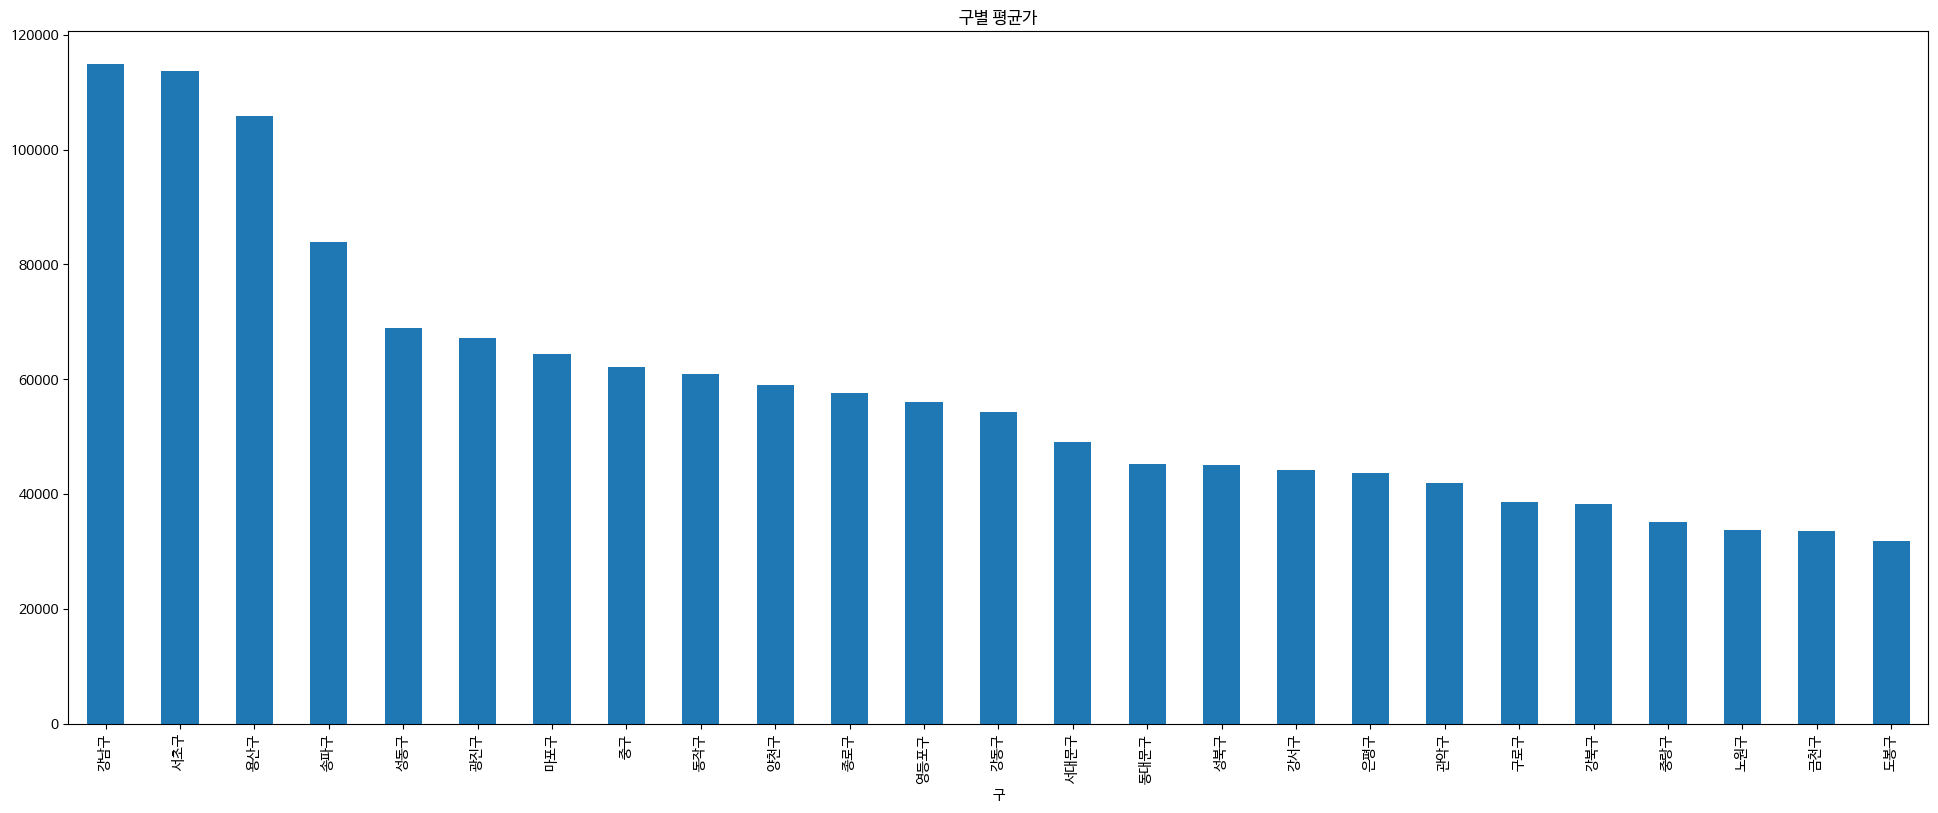

In [49]:
plt.figure(figsize=(24, 9))
mean_val_by_gu.plot.bar()
plt.title("구별 평균가")

In [50]:
list_of_gu = dt["구"].unique().tolist()

In [51]:
len(list_of_gu)

25

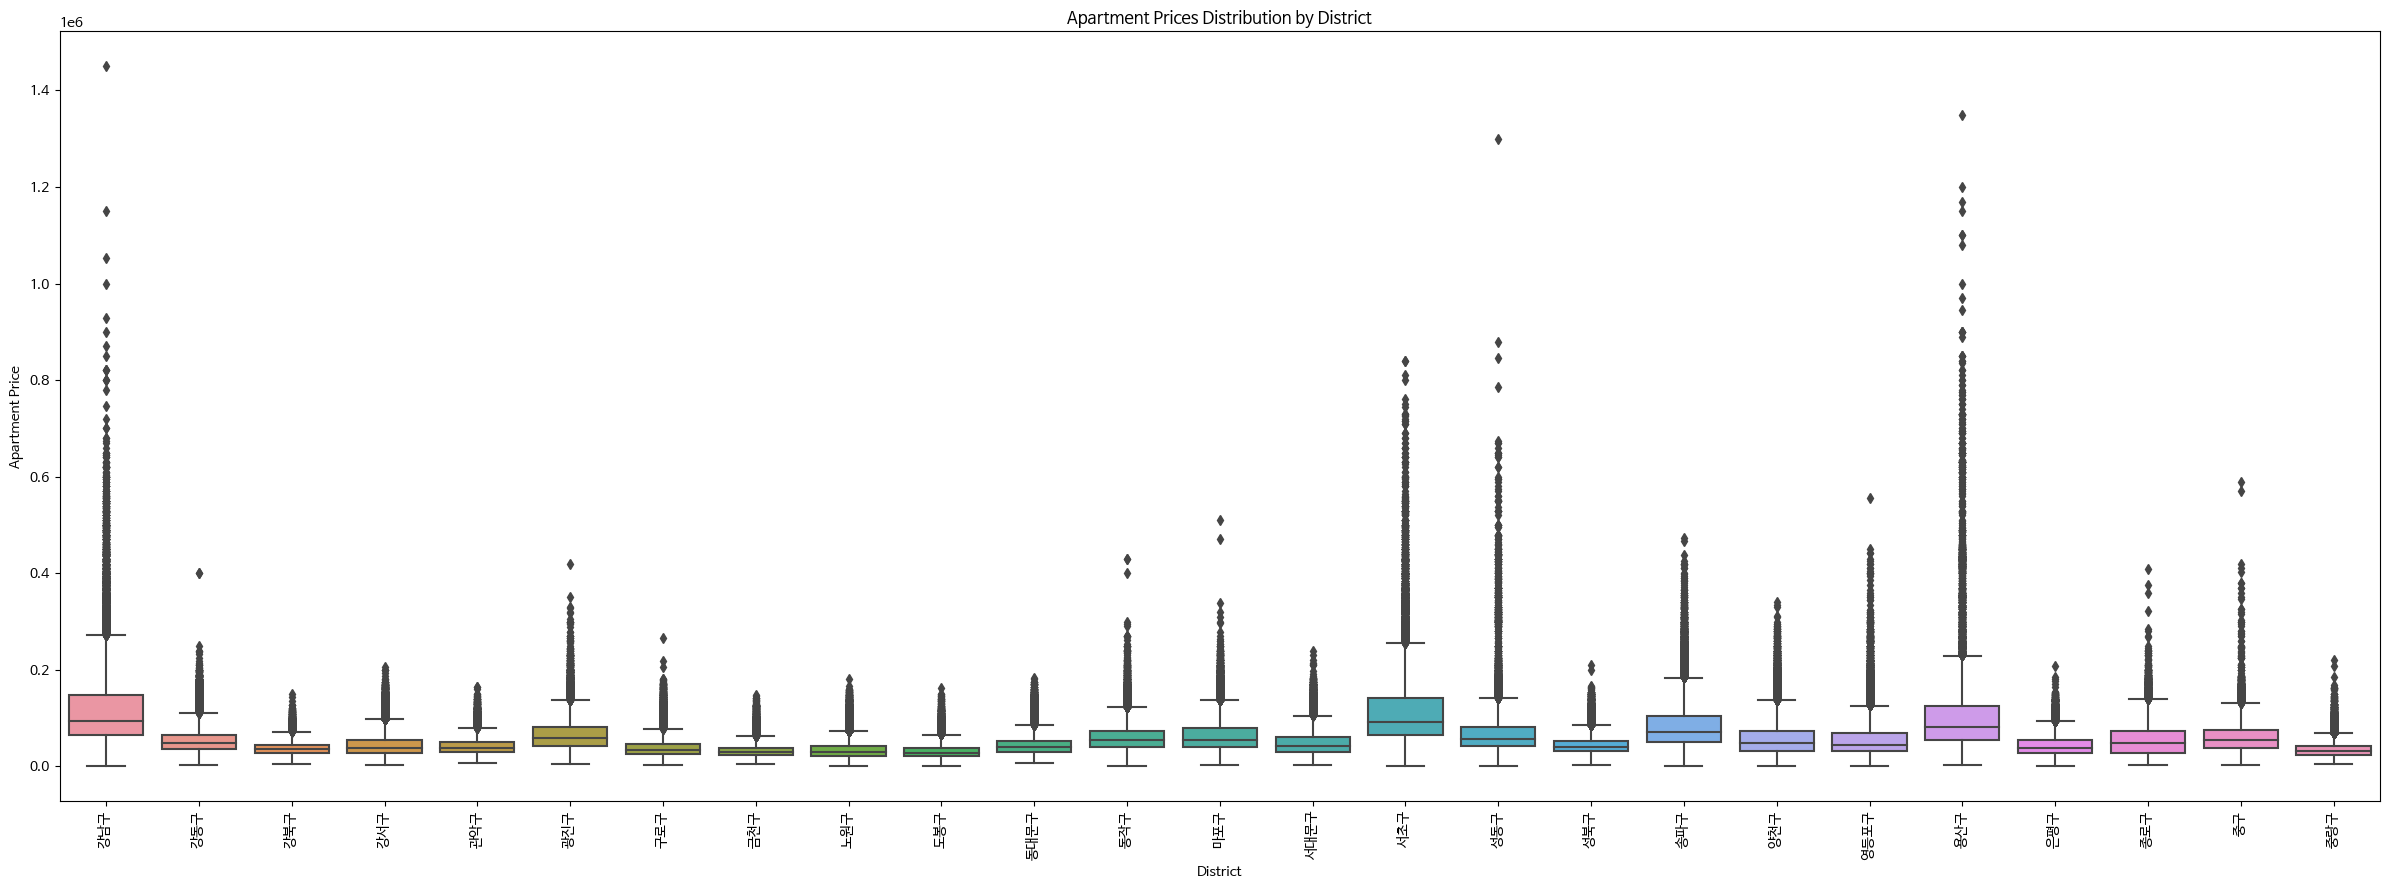

In [52]:
plt.figure(figsize=(24, 9))
sns.boxplot(data=dt, x="구", y="target")

plt.xticks(rotation=90)
plt.title('Apartment Prices Distribution by District')
plt.xlabel('District')
plt.ylabel('Apartment Price')

plt.tight_layout()
plt.show()

In [53]:
dt['계약년'] = dt['계약년월'].map(lambda x : x // 100)
dt['계약월'] = dt['계약년월'].map(lambda x : x % 100)
del dt['계약년월']

In [54]:
dt_test['계약년'] = dt_test['계약년월'].map(lambda x : x // 100)
dt_test['계약월'] = dt_test['계약년월'].map(lambda x : x % 100)
del dt_test['계약년월']

In [55]:
dt = dt.drop(columns = ['번지', '본번', '부번', '아파트명'])
dt_test = dt_test.drop(columns = ['번지', '본번', '부번', '아파트명'])

In [56]:
dt.rename(columns={'도로명': 'street'}, inplace=True)
dt_test.rename(columns={'도로명': 'street'}, inplace=True)

In [57]:
# 언선님이 해준 좌표 작업은 나중에 추가하기
# coords = pd.read_csv("좌표.csv")

In [137]:
# coords.set_index('street', inplace=True)

In [138]:
# for index, row in dt.iterrows():
#     if pd.isnull(row['좌표X']) or pd.isnull(row['좌표Y']):
#         street = row['street']
#         if street in coords.index:
#             dt.at[index, '좌표X'] = coords.loc[street, '좌표X']
#             dt.at[index, '좌표Y'] = coords.loc[street, '좌표Y']

In [139]:
# for index, row in dt_test.iterrows():
#     if pd.isnull(row['좌표X']) or pd.isnull(row['좌표Y']):
#         street = row['street']
#         if street in coords.index:
#             dt.at[index, '좌표X'] = coords.loc[street, '좌표X']
#             dt.at[index, '좌표Y'] = coords.loc[street, '좌표Y']

In [140]:
# dt['좌표X'].isnull().sum()

11431

In [141]:
# dt_test['좌표X'].isnull().sum()

6562

In [58]:
df_interest_rate.rename(columns={'날짜': 'date'}, inplace=True)

In [59]:
df_interest_rate['date'] = pd.to_datetime(df_interest_rate['date'])

In [60]:
dt["date"] = pd.to_datetime(dt['계약년'].astype(str) + '-' + dt['계약월'].astype(str) + '-' + dt['계약일'].astype(str))
dt_test["date"] = pd.to_datetime(dt['계약년'].astype(str) + '-' + dt['계약월'].astype(str) + '-' + dt['계약일'].astype(str))

In [61]:
dt_merge = pd.merge(dt, df_interest_rate, on = 'date', how='left')
dt_test_merge = pd.merge(dt_test, df_interest_rate, on = 'date', how='left')

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [64]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_merge['is_test'] = 0
dt_test_merge['is_test'] = 1
concat = pd.concat([dt_merge, dt_test_merge])     # 하나의 데이터로 만들어줍니다.

In [65]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


In [66]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [67]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

전용면적(㎡)                         0
계약일                             0
층                               0
건축년도                            0
street                          0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-주거전용면적                   876170
k-전용면적별세대현황(60㎡이하)         876170
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-85㎡~135㎡이하               876170
k-수정일자                     876170
고용보험관리번호                   920757
경비비관리형태                    877561
세대전기계약방법                   885389
청소비관리형태                    877751
건축면적                       876279
주차대수                       876277
기타/의무/임대/임의=1/2/3/4        876125
단지승인일                      876854
사용허가여부                     876125
관리비 업로드                    876125
좌표X                        876232
좌표Y                        876232
단지신청일                      876187
target                       9272
is_public                       0
구             

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [68]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [69]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

전용면적(㎡)                        0
계약일                            0
층                              0
건축년도                           0
street                         0
k-주거전용면적                  876170
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호                  920757
경비비관리형태                   877561
세대전기계약방법                  885389
청소비관리형태                   877751
건축면적                      876279
주차대수                      876277
기타/의무/임대/임의=1/2/3/4       876125
단지승인일                     876854
사용허가여부                    876125
관리비 업로드                   876125
좌표X                       876232
좌표Y                       876232
단지신청일                     876187
target                      9272
is_public                      0
구                              0
동                              0
계약년                            0
계약월                            0
date                           0
기준금리      

In [70]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 32 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   전용면적(㎡)                 1128094 non-null  float64       
 1   계약일                     1128094 non-null  int64         
 2   층                       1128094 non-null  int64         
 3   건축년도                    1128094 non-null  int64         
 4   street                  1128094 non-null  object        
 5   k-주거전용면적                251924 non-null   float64       
 6   k-전용면적별세대현황(60㎡이하)      251924 non-null   float64       
 7   k-전용면적별세대현황(60㎡~85㎡이하)  251924 non-null   float64       
 8   k-85㎡~135㎡이하            251924 non-null   float64       
 9   k-수정일자                  251924 non-null   object        
 10  고용보험관리번호                207337 non-null   object        
 11  경비비관리형태                 250533 non-null   object        
 12  세대전기계약방법         

In [71]:
concat_select.columns

Index(['전용면적(㎡)', '계약일', '층', '건축년도', 'street', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_public', '구', '동', '계약년', '계약월', 'date', '기준금리',
       'is_test'],
      dtype='object')

In [72]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [73]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [74]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

전용면적(㎡)                   0
계약일                       0
층                         0
건축년도                      0
street                    0
k-주거전용면적                  0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
사용허가여부                    0
관리비 업로드                   0
좌표X                       0
좌표Y                       0
단지신청일                     0
target                    0
is_public                 0
구                         0
동                         0
계약년                       0
계약월                       0
date                      0
기준금리                      0
is_test                   0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

In [237]:
# # 이상치 제거 이전의 shape은 아래와 같습니다.
# print(concat_select.shape)

(1128094, 35)


In [238]:
# # 이상치 제거 방법에는 IQR을 이용하겠습니다.
# def remove_outliers_iqr(dt, column_name):
#     df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
#     df_test = dt.query('is_test == 1')

#     Q1 = df[column_name].quantile(0.25)
#     Q3 = df[column_name].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

#     result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
#     return result

In [239]:
# # 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
# concat_select = remove_outliers_iqr(concat_select, '전용면적(㎡)')

In [240]:
# # 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
# print(concat_select.shape)

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [75]:
concat_select.columns

Index(['전용면적(㎡)', '계약일', '층', '건축년도', 'street', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_public', '구', '동', '계약년', '계약월', 'date', '기준금리',
       'is_test'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [76]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

In [77]:
# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}

In [78]:
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}

In [79]:
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}

In [80]:
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

In [81]:
concat_select['구_encoded'] = concat_select["구"].map(gu_mapping1)

In [82]:
concat_select['구_std'] = concat_select["구"].map(gu_mapping2)

In [83]:
concat_select['동_encoded'] = concat_select["동"].map(dong_mapping1)

In [84]:
concat_select['동_std'] = concat_select["동"].map(dong_mapping2)

In [86]:
seoul_bds = ["강남구", "영등포구", "용산구"]

In [89]:
concat_select["has_bds"] = concat_select["구"].apply(lambda x : 1 if x in seoul_bds else 0)

In [100]:
concat_select.columns

Index(['전용면적(㎡)', '계약일', '층', '건축년도', 'street', 'k-주거전용면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', 'is_public', '구', '동', '계약년', '계약월', 'date', '기준금리',
       'is_test', '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds'],
      dtype='object')

### add 구별 특성

In [92]:
df_zones_original = pd.read_csv("./extra_data/2022년_도시계획현황통계_용도지역(시군구별)_서울시.CSV", encoding='euc-kr', skiprows=1)

In [93]:
df_zones_original = df_zones_original.dropna()

In [94]:
df_zones_original.columns

Index(['시군구', '도시지역 면적', '주거지역_소계', '주거지역_비율', '주거지역_전용주거_소계 ', '주거지역_1종_전용주거',
       '주거지역_2종_전용주거', '주거지역_일반주거지역_소계 ', '주거지역_1종일반주거', '주거지역_2종일반주거',
       '주거지역_3종일반주거', '주거지역_준주거지역', '상업지역_소계', '상업지역_비율', '상업지역_중심상업',
       '상업지역_일반상업', '상업지역_근린상업 ', '상업지역_유통상업', '공업지역_소계', '공업지역_비율',
       '공업지역_전용공업', '공업지역_일반공업', '공업지역_준공업', '녹지지역_소계', '녹지지역_비율', '녹지지역_보전녹지',
       '녹지지역_자연녹지', '녹지지역_생산녹지'],
      dtype='object')

In [97]:
df_zone_ratio = df_zones_original[['시군구', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율']]

In [101]:
df_zone_ratio.rename(columns={'시군구': '구'}, inplace=True)

In [102]:
df_zone_ratio

,구,주거지역_비율,상업지역_비율,공업지역_비율,녹지지역_비율
0,종로구,41.01,12.25,0.00,46.74
1,중구,60.24,39.51,0.00,0.25
2,용산구,52.17,7.18,0.00,40.64
3,성동구,59.20,2.82,12.21,25.78
4,광진구,67.90,1.21,0.00,30.89
5,동대문구,91.49,5.82,0.00,2.69
6,중랑구,58.40,1.93,0.00,39.67
7,성북구,72.25,1.63,0.00,26.13
8,강북구,46.11,1.15,0.00,52.74
9,도봉구,41.81,1.29,7.07,49.83


In [103]:
concat_select_merge = pd.merge(left=concat_select, right=df_zone_ratio, on='구', how='left')

In [105]:
concat_select = concat_select_merge

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [107]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.128094e+06
mean     1.998791e+03
std      9.358540e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [108]:
concat_select['yrs_diff_built_contract'] = concat_select['계약년'] - concat_select['건축년도']

In [109]:
concat_select['built_in3yrs'] = concat_select['yrs_diff_built_contract'].apply(lambda x : 1 if x <= 3 else 0)

In [110]:
concat_select['built_in5yrs'] = concat_select['yrs_diff_built_contract'].apply(lambda x : 1 if x <= 5 else 0)

In [111]:
concat_select['built_over30yrs'] = concat_select['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 30 else 0)

In [112]:
concat_select['built_over35yrs'] = concat_select['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 35 else 0)

In [113]:
concat_select['built_over40yrs'] = concat_select['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 40 else 0)

In [114]:
concat_select['road'] = concat_select['street'].apply(lambda x : x.split()[0] if len(x.split()) > 0 else x)

In [115]:
concat_select['on_main_st'] = concat_select['road'].apply(lambda x: not any(char.isdigit() for char in x))
del concat_select['road']

In [116]:
concat_select.columns = concat_select.columns.str.replace('[^\w\s]', '')
concat_select.columns = concat_select.columns.str.replace(' ', '_')

In [117]:
concat_select.shape

(1128094, 48)

In [118]:
concat_select.columns

Index(['전용면적', '계약일', '층', '건축년도', 'street', 'k주거전용면적', 'k전용면적별세대현황60이하',
       'k전용면적별세대현황6085이하', 'k85135이하', 'k수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타의무임대임의1234', '단지승인일',
       '사용허가여부', '관리비_업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_public', '구',
       '동', '계약년', '계약월', 'date', '기준금리', 'is_test', '구_encoded', '구_std',
       '동_encoded', '동_std', 'has_bds', '주거지역_비율', '상업지역_비율', '공업지역_비율',
       '녹지지역_비율', 'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs',
       'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'on_main_st'],
      dtype='object')

In [119]:
del concat_select['좌표X']

In [120]:
del concat_select['좌표Y']

In [ ]:
# from geopy.distance import geodesic

# # Function to calculate distances between two points
# def calculate_distance(lat1, lon1, lat2, lon2):
#     coords_1 = (lat1, lon1)
#     coords_2 = (lat2, lon2)
#     return geodesic(coords_1, coords_2).meters  # Calculate distance in meters

# # Iterate over each row in concat_select
# for index, row in concat_select.iterrows():
#     property_lat = row['좌표Y']
#     property_lon = row['좌표X']
    
#     # Initialize counters for bus and metro stations within different distances
#     bus_500m = 0
#     bus_1km = 0
#     bus_3km = 0
#     metro_500m = 0
#     metro_1km = 0
#     metro_3km = 0
    
#     # Iterate over each bus station
#     for bus_index, bus_row in df_bus.iterrows():
#         bus_lat = bus_row['Y좌표']
#         bus_lon = bus_row['X좌표']
        
#         # Calculate distance between property and bus station
#         distance = calculate_distance(property_lat, property_lon, bus_lat, bus_lon)
        
#         # Update counters based on distance
#         if distance <= 500:
#             bus_500m += 1
#         elif distance <= 1000:
#             bus_1km += 1
#         elif distance <= 3000:
#             bus_3km += 1
            
#     for metro_index, metro_row in df_metro.iterrows():
#         metro_lat = metro_row['위도']
#         metro_lon = metro_row['경도']
        
#         # Calculate distance between property and bus station
#         distance = calculate_distance(property_lat, property_lon, metro_lat, metro_lon)
        
#         # Update counters based on distance
#         if distance <= 500:
#             metro_500m += 1
#         elif distance <= 1000:
#             metro_1km += 1
#         elif distance <= 3000:
#             metro_3km += 1
#     # Iterate over each metro station (assuming the same process as for bus stations)
#     # Update counters similarly
    
#     # Add new columns to concat_select
#     concat_select.at[index, 'bus_500m'] = bus_500m
#     concat_select.at[index, 'bus_1km'] = bus_1km
#     concat_select.at[index, 'bus_3km'] = bus_3km
#     concat_select.at[index, 'metro_500m'] = metro_500m
#     concat_select.at[index, 'metro_1km'] = metro_1km
#     concat_select.at[index, 'metro_3km'] = metro_3km


## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [189]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 45) (9272, 45)


In [190]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [191]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k주거전용면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하', 'k85135이하', '건축면적', '주차대수', 'target', 'is_public', '계약년', '계약월', '기준금리', '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', 'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'on_main_st']
범주형 변수: ['street', 'k수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비_업로드', '단지신청일', '구', '동', 'date']


In [192]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 14/14 [00:03<00:00,  3.52it/s]


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [193]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [194]:
dt_train.columns

Index(['전용면적', '계약일', '층', '건축년도', 'street', 'k주거전용면적', 'k전용면적별세대현황60이하',
       'k전용면적별세대현황6085이하', 'k85135이하', 'k수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타의무임대임의1234', '단지승인일',
       '사용허가여부', '관리비_업로드', '단지신청일', 'target', 'is_public', '구', '동', '계약년',
       '계약월', 'date', '기준금리', '구_encoded', '구_std', '동_encoded', '동_std',
       'has_bds', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율',
       'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs',
       'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'on_main_st'],
      dtype='object')

In [195]:
drop_cols_before_train = ['street', '구', '동', '계약월', '계약일', '고용보험관리번호', 'k수정일자', '관리비_업로드', '기타의무임대임의1234']

In [196]:
dt_train = dt_train.drop(columns=drop_cols_before_train)
dt_test = dt_test.drop(columns=drop_cols_before_train)

In [197]:
dt_train.columns

Index(['전용면적', '층', '건축년도', 'k주거전용면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하',
       'k85135이하', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '단지승인일',
       '사용허가여부', '단지신청일', 'target', 'is_public', '계약년', 'date', '기준금리',
       '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds', '주거지역_비율',
       '상업지역_비율', '공업지역_비율', '녹지지역_비율', 'yrs_diff_built_contract',
       'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs',
       'built_over40yrs', 'on_main_st'],
      dtype='object')

In [198]:
print(dt_train.shape, dt_test.shape)

(1118822, 36) (9272, 36)


In [199]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

In [200]:
# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [201]:
X_test = dt_test.drop(['target'], axis=1)

In [202]:
import xgboost as xgb

In [203]:
# Define parameters for XGBRegressor
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression task
    'eval_metric': 'rmse',  # Root Mean Squared Error for evaluation
    'max_depth': 20,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 42
}

# Create and train the XGBRegressor model
model_xgb1 = xgb.XGBRegressor(**params)
model_xgb1.fit(X_train, y_train)

# Make predictions on the validation set
pred_xgb1 = model_xgb1.predict(X_val)

In [204]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred_xgb1))}')

RMSE test: 7236.763387208487


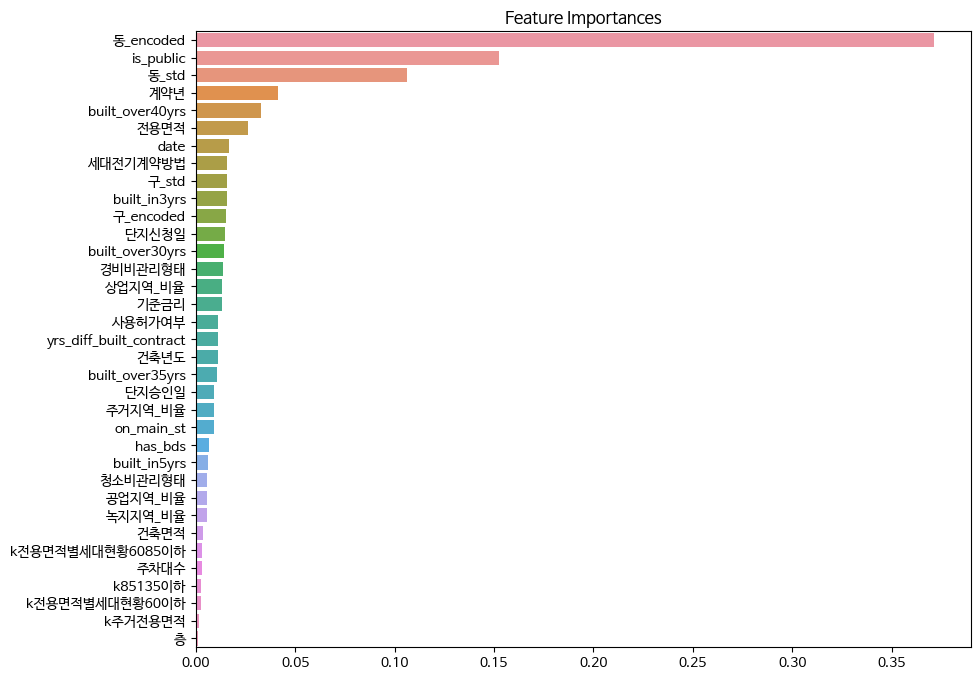

In [205]:
importances = pd.Series(model_xgb1.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [206]:
# Get feature importances
importances = model_xgb1.feature_importances_

# Create a DataFrame with feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values(by='Importance')

# Get the names of the 10 least important features
features_to_drop = feature_importance_df.head(10)['Feature']

# Drop the least important features from X_train and X_val
X_train.drop(columns=features_to_drop, inplace=True)
X_val.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

In [207]:
# Create and train the XGBRegressor model
model_xgb2 = xgb.XGBRegressor(**params)
model_xgb2.fit(X_train, y_train)

# Make predictions on the validation set
pred_xgb2 = model_xgb2.predict(X_val)

In [208]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred_xgb2))}')

RMSE test: 7683.2718283395225


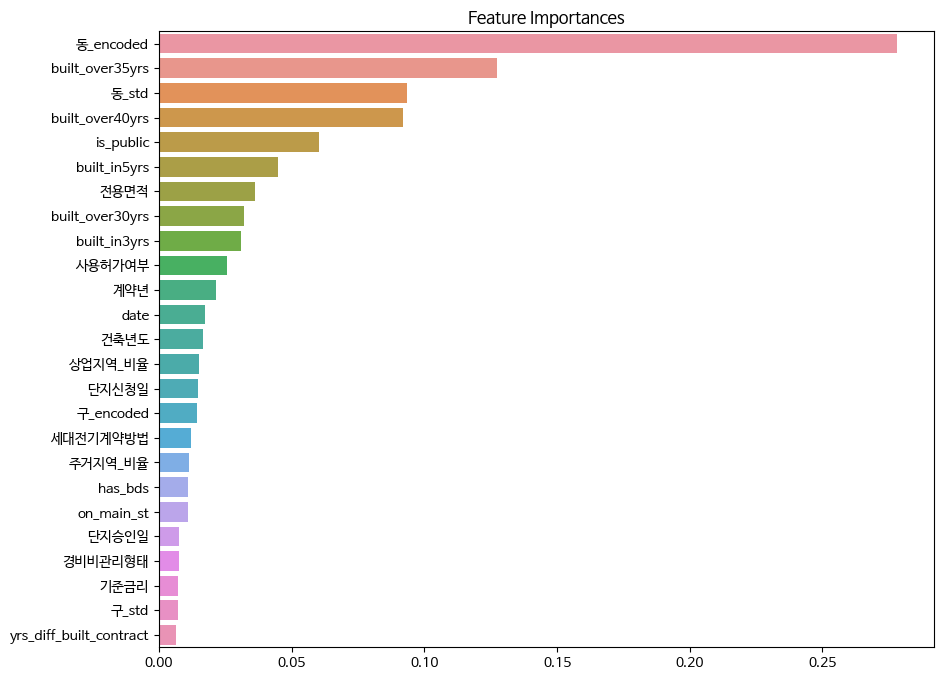

In [209]:
importances = pd.Series(model_xgb2.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [210]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model_xgb2.pkl', 'wb') as f:
    pickle.dump(model_xgb2, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [312]:
# # Permutation importance 방법을 변수 선택에 이용해보겠습니다.
# perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
#                              scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
#                              random_state = 42,
#                              n_iter=3).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1115100604.8982 ± 16011314.4157,전용면적
1012592379.8384 ± 9979412.9561,동_encoded
998076962.4988 ± 7148859.3022,계약년월
408483981.9837 ± 1699485.3199,동_std
179847539.9027 ± 4178794.3527,건축년도
39009181.6323 ± 733301.9405,부번
27655840.5256 ± 658130.5952,도로명
23801508.9218 ± 1016627.3693,동
21363376.5972 ± 192892.0522,yrs_diff_built_contract
20618314.2286 ± 243254.3049,구_encoded


## 6. Inference

In [211]:
# 저장된 모델을 불러옵니다.
with open('model_xgb2.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [212]:
%%time
X_test.columns = X_test.columns.str.replace('[^\w\s]', '')
X_test.columns = X_test.columns.str.replace(' ', '_')

CPU times: user 687 µs, sys: 0 ns, total: 687 µs
Wall time: 697 µs


In [213]:
# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model1.predict(X_test)

In [214]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

## 7. Output File Save

In [153]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [ ]:
import lightgbm as lgb

In [322]:
X_train.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       'k주거전용면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하', 'k85135이하', 'k수정일자',
       '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비_업로드', '좌표X', '좌표Y', '단지신청일',
       'is_public', '구', '동', '계약년', '구_encoded', '구_std', '동_encoded',
       '동_std', 'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs',
       'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'has_bds',
       'road', 'on_main_st'],
      dtype='object')

In [ ]:
# X_train = X_train.drop(columns=['구', '동', '좌표X', '좌표Y', '본번', '부번', '아파트명', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', 'road'])
# X_val = X_val.drop(columns=['구', '동', '좌표X', '좌표Y', '본번', '부번', '아파트명', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', 'road'])
# X_test = X_test.drop(columns=['구', '동', '좌표X', '좌표Y', '본번', '부번', '아파트명', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', 'road'])

In [333]:
X_train = X_train.drop(columns=['road'])

In [334]:
X_val = X_val.drop(columns=['road'])
X_test = X_test.drop(columns=['road'])

In [335]:
# Define parameters for LGBMRegressor
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth' : 20,
    'num_leaves': 1023,
    'min_child_samples' : 50,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'random_state': 42
}

# Create and train the LGBMRegressor model
model_lgb1 = lgb.LGBMRegressor(**params)
model_lgb1.fit(X_train, y_train)

# Make predictions on the validation set
pred_lgb1 = model_lgb1.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3995
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 33
[LightGBM] [Info] Start training from score 58003.281782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


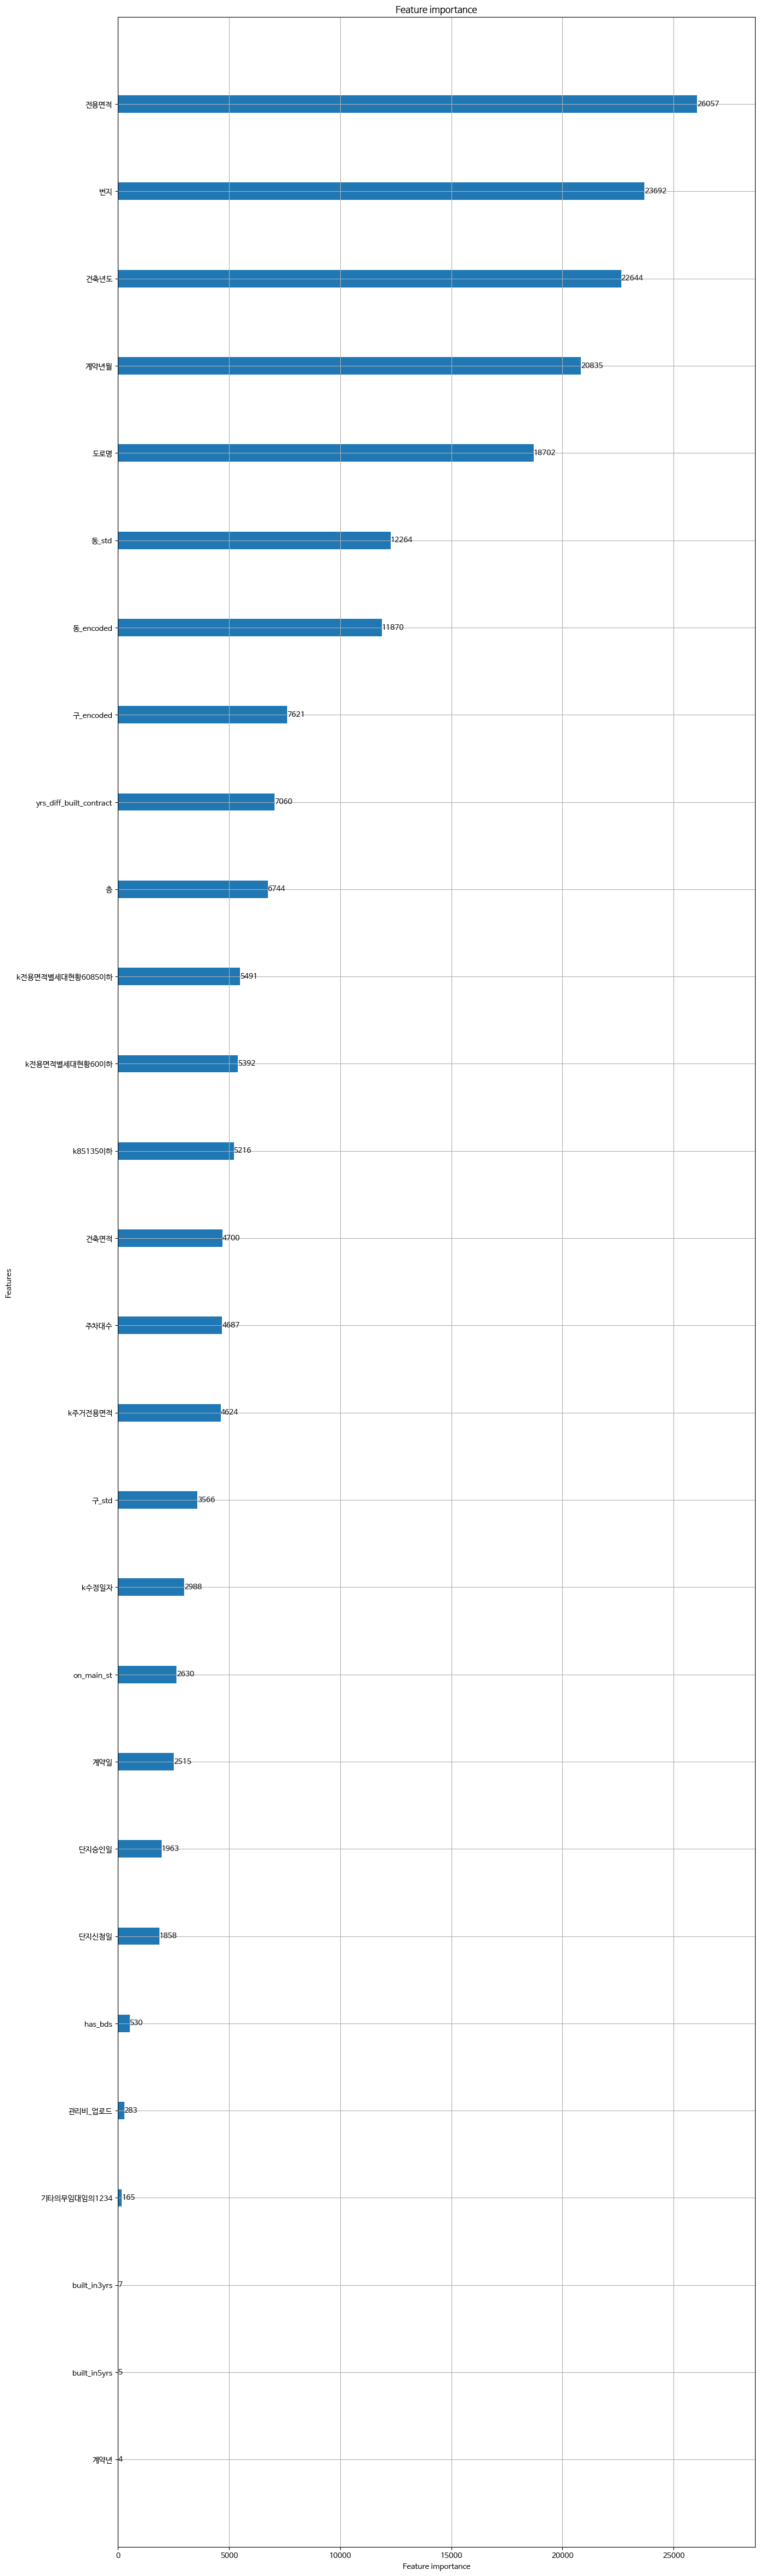

In [336]:
lgb.plot_importance(model_lgb1, max_num_features=300, importance_type='split', figsize=(15, 60))
plt.show()

In [337]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model_lgb1.pkl', 'wb') as f:
    pickle.dump(model_lgb1, f)

In [342]:
# 저장된 모델을 불러옵니다.
with open('model_lgb1.pkl', 'rb') as f:
    model_lgb1 = pickle.load(f)

In [ ]:
X_test = X_test.drop(columns=['구', '동', '좌표X', '좌표Y', '본번', '부번', '아파트명', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', 'road'])

In [338]:
X_test.columns

Index(['번지', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k주거전용면적',
       'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하', 'k85135이하', 'k수정일자', '건축면적',
       '주차대수', '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비_업로드', '단지신청일',
       'is_public', '계약년', '구_encoded', '구_std', '동_encoded', '동_std',
       'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs',
       'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'has_bds',
       'on_main_st'],
      dtype='object')

In [345]:
%%time
X_test.columns = X_test.columns.str.replace('[^\w\s]', '')
X_test.columns = X_test.columns.str.replace(' ', '_')

CPU times: user 693 µs, sys: 0 ns, total: 693 µs
Wall time: 703 µs


In [346]:
# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model_lgb1.predict(X_test)

ValueError: Number of features of the model must match the input. Model n_features_ is 33 and input n_features is 45

In [343]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)